In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import spherical_volume, volume_fourier, volume_comp, mip_z,create_mask
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

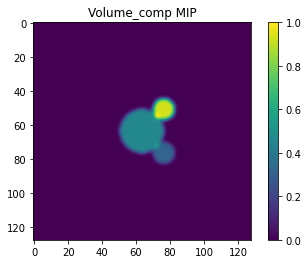

In [3]:
nx = 128
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, True))
vol_fourier, X, Y, Z, _, _, _ = volume_fourier(jnp.fft.ifftshift(vol), dimensions)

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

Apply Fourier mask to volume to work with the lower frequencies only

In [4]:
mask = create_mask(X, Y, Z, (0,0,0),1)
x_size = np.sum(mask[:,0,0])
y_size = np.sum(mask[0,:,0])
z_size = np.sum(mask[0,0,:])

vol_fourier_masked = vol_fourier[mask == 1]
vol_fourier_masked.shape
print(x_size*y_size*z_size)

68921.0


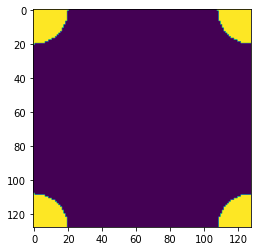

In [5]:
mip_z(mask)

Generate projections (in Fourier domain)

In [6]:
@jax.jit
def slice_func(v, angles):
    projection, _, _, _ = project(mask * v, X, Y, Z, angles)
    return projection

@jax.jit
def slice_func_array(v, angles):    
    return jax.vmap(slice_func, in_axes = (None, 0))(v, angles)

In [8]:
N = 100
angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true)
print(time.time()-start)

0.14860296249389648


In [9]:
jnp.sum(mask[:,:,0])

DeviceArray(1257., dtype=float64)

In [10]:
nx*nx

16384

Loss function given volume and angles, for one image and for many (batches of images). We have a separate loss function for each angles-image pair.

In [11]:
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, img):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    return 1/(2* 1257) * l2sq(slice_func(v, angles) - img)   #1257 = number of pixels in mask at z=0


@jax.jit
def loss_func_batched(v, angles, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0))(v, angles, imgs)

And the gradients of the above, with respect to angles

In [12]:
@jax.jit
def grad_loss_angles(v, angles, img):
    return jax.grad(loss_func, argnums = 1)(v, angles, img)

@jax.jit
def grad_loss_angles_batched(v, angles, imgs):
    return jax.vmap(grad_loss_angles, in_axes = (None, 0, 0))(v, angles, imgs)

In [14]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(ll.shape)

0.17787814140319824
(100,)


In [16]:
start = time.time()
dl = grad_loss_angles(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(dl.shape)

0.0051229000091552734
(3,)


In [19]:
start = time.time()
dl = grad_loss_angles_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(dl.shape)

0.3684110641479492
(100, 3)


Gradients with respect to volume pixels, over all (or a batch of) images

In [20]:
@jax.jit
def grad_loss_volume(v, angles, img):
    return jax.grad(loss_func)(v, angles, img)

@jax.jit
def grad_loss_volume_batched(v, angles, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0))(v, angles, imgs), axis=0)

In [22]:
start = time.time()
ll = grad_loss_volume(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(ll.shape)

0.18738317489624023
(128, 128, 128)


In [24]:
start = time.time()
ll = grad_loss_volume_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(ll.shape)

30.013279914855957
(128, 128, 128)


## Gradient descent with respect to angles

In [19]:
alpha = 0.00000001
a = jnp.array(np.random.rand(N, 3)*np.pi*2)
a = angles_true + 0.01*a
N_iter = 1000

for i in range(N_iter):
        
    if jnp.mod(i,10) == 0:
    #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(vol_fourier, a, imgs))))
        
    a = a - alpha * jnp.conj(grad_loss_angles_batched(vol_fourier, a, imgs))
    
max_err = jnp.mean(jnp.abs(a - angles_true))
print("mean(a-a_true) = " + str(max_err))

Iter 0: mean loss = 1124.6326146850104
Iter 10: mean loss = 881.1112171496092
Iter 20: mean loss = 697.0096018959235
Iter 30: mean loss = 558.0149625042707
Iter 40: mean loss = 452.4989750604663
Iter 50: mean loss = 372.15876541400314
Iter 60: mean loss = 310.536496588857
Iter 70: mean loss = 262.92733177138086
Iter 80: mean loss = 225.792402670188
Iter 90: mean loss = 196.4664639118452
Iter 100: mean loss = 173.07338714109804
Iter 110: mean loss = 154.2117265358578
Iter 120: mean loss = 138.824232777776
Iter 130: mean loss = 126.12615846905686
Iter 140: mean loss = 115.54040741224426
Iter 150: mean loss = 106.59925769924892
Iter 160: mean loss = 98.95492944437811
Iter 170: mean loss = 92.36859553086627
Iter 180: mean loss = 86.63494676095053
Iter 190: mean loss = 81.59429036894073
Iter 200: mean loss = 77.13125770113415
Iter 210: mean loss = 73.14809437450954
Iter 220: mean loss = 69.5689551656578
Iter 230: mean loss = 66.33454870873203
Iter 240: mean loss = 63.391258173606694
Iter 25

In [20]:
max_err = jnp.max(jnp.abs(a - angles_true))
print("max(a-a_true) = " + str(max_err))

max(a-a_true) = 0.05531752366140097


## Gradient descent with respect to volume

In [56]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))*jnp.max(jnp.abs(imgs[0])) * mask
#v0 = vol_fourier + 0.1*v * mask
alpha = 10000
batch_size = 10
N_iter = 1000 * 10 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true, imgs))))
        
    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], imgs[idx]))
    
jnp.max(jnp.abs(v - vol_fourier))

Iter 0: mean loss = 9144520.061897371
Iter 100: mean loss = 1196933.0048314699
Iter 200: mean loss = 449801.5789573613
Iter 300: mean loss = 230543.18507991053
Iter 400: mean loss = 139337.00930360236
Iter 500: mean loss = 93116.8626250749
Iter 600: mean loss = 65976.69875235845
Iter 700: mean loss = 49297.62984242703
Iter 800: mean loss = 38348.45190236091
Iter 900: mean loss = 30509.231120887052
Iter 1000: mean loss = 24746.765429883086
Iter 1100: mean loss = 20491.236701828184
Iter 1200: mean loss = 17171.059026985822
Iter 1300: mean loss = 14634.29530793081
Iter 1400: mean loss = 12615.426191394801
Iter 1500: mean loss = 10986.115533513183
Iter 1600: mean loss = 9643.892968713235
Iter 1700: mean loss = 8499.370024452768
Iter 1800: mean loss = 7578.723567239425
Iter 1900: mean loss = 6780.8596432132945
Iter 2000: mean loss = 6110.44986666475
Iter 2100: mean loss = 5514.324974719069
Iter 2200: mean loss = 5003.835659026577
Iter 2300: mean loss = 4561.595691990797
Iter 2400: mean loss

DeviceArray(19542.24613796, dtype=float64)

In [57]:
jnp.max(jnp.abs(v*mask - vol_fourier))

DeviceArray(19542.24613796, dtype=float64)

Text(0.5, 1.0, 'Volume_comp MIP')

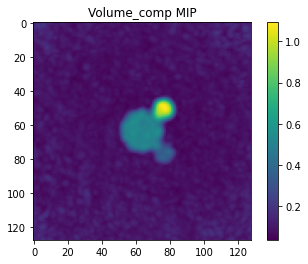

In [58]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Volume_comp MIP')

Text(0.5, 1.0, 'Volume_comp MIP')

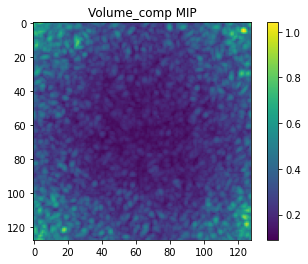

In [55]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v)))))
plt.colorbar()
plt.title('Volume_comp MIP')

In [51]:
imgs.shape

(100, 128, 128)